In [1]:
# Standard libraries
import numpy as np
import json
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "mesoscopic-functional-connectivity"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from codes.lib.stat import graph_lib
from codes.lib.info_metrics.corr_lib import corr, crossCorr
from codes.lib.data_io.qt_wrapper import gui_fnames, gui_fpath
from codes.lib.data_io.yaro.data_fc_db import DataFCDatabase
import codes.lib.plots.connectomics as connectomics
import codes.lib.plots.connectomics_db as connectomics_db
import codes.lib.plots.data_plots as data_plots

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/mesoscopic-functional-connectivity


# Reading Data
* Automatically find subfolders for FC, data and behaviour
* Parse filenames and folders to identify mice, dates and analysis types
* Read all datasets into memory (so far works)

**TODO**:
* Integrate connectomics analysis with pandas

In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
params['root_path_data']  = gui_fpath("Path to data collection",  './')
#params['root_path_paw']   = gui_fpath("Path to Paw data",         params['root_path_data'])
#params['root_path_lick']  = gui_fpath("Path to Lick data",        params['root_path_paw'])
#params['root_path_whisk'] = gui_fpath("Path to Whisk Data",       params['root_path_lick'])
params['root_path_te']    = gui_fpath("Select TE results folder", params['root_path_data'])

In [3]:
dataDB = DataFCDatabase(params)

Target trial within [0, 8] sec. Total target timesteps 161
Searching for TE files
Total user files in dataset raw_delay_3_window_4 is 774
Searching for channel labels
Searching for data files
No paw path provided, skipping
No lick path provided, skipping
No whisk path provided, skipping


In [4]:
#display(dataDB.summary)
#display(dataDB.summaryTE)

In [5]:
dataDB.read_te_files()
dataDB.read_neuro_files()
dataDB.read_resample_paw_files()
dataDB.read_resample_lick_files()   # Currently does not work. Ask Yaro if we need it
dataDB.read_resample_whisk_files()

IntProgress(value=0, description='Reading TE files', max=774)

IntProgress(value=0, description='Read Neuro Data:', max=66)

Calculated performance 0.231 does not match external 0.27598566308243727
Calculated performance 0.37388392857142855 does not match external 0.39691943127962087
Calculated performance 0.4024691358024691 does not match external 0.4527777777777778
Calculated performance 0.5891891891891892 does not match external 0.6337209302325582
Calculated performance 0.5015625 does not match external 0.6257309941520468
Calculated performance 0.6888888888888889 does not match external 0.7560975609756098
Calculated performance 0.6612903225806451 does not match external 0.8913043478260869
Calculated performance 0.6442857142857142 does not match external 0.9241803278688525
Calculated performance 0.7163677130044843 does not match external 0.8987341772151899
Calculated performance 0.7048951048951049 does not match external 0.8689655172413793
Calculated performance 0.5771428571428572 does not match external 0.7984189723320159
Calculated performance 0.046153846153846156 does not match external 0.05
Calculated 

In [6]:
pTHR = 0.7
dataDB.mark_days_expert_naive(pTHR)

# Analysis

## Performance

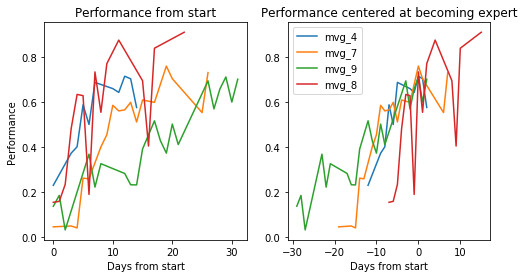

In [7]:
data_plots.plot_performance_by_days(dataDB)

# Basic TE info

# **TODO**:
* Make sure all routines work
* If necessary, convert some routines to seaborn
* Remove ugly white bezel for circles
* Redo everything for downsampled data
* Rewrite rangeByDays to normalized days

* Impl ranges generic for all procedures
    - Get rid of timestep and rangesSec parameter for final routines
    - Uniform rangesSec only for generic plot, only one tuple (secStart, secEnd)
    - Impl routine for ranged FC extraction directly in dataDB

* Delete all procedures that are not in use
* Parallelize plotting

For Naive MultivariateTE mean log p-val is -49.64763567150427
For Expert MultivariateTE mean log p-val is -67.73560148025757
For Naive BivariateTE mean log p-val is -16.666065286616682
For Expert BivariateTE mean log p-val is -19.252289370181344


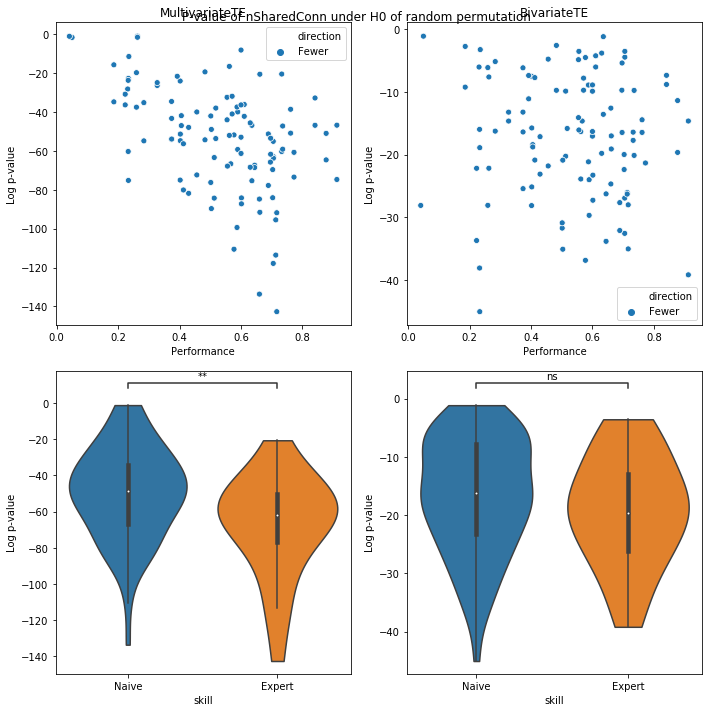

In [10]:
#rangesSec = {"whisk":(3, 3.5)}
rangesSec = None

# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_nconn_vs_time", rangesSec=rangesSec, ext='.svg')
# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_nconn_vs_days", rangesSec=rangesSec, ext='.svg')
# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_fc_vs_time", rangesSec=rangesSec, ext='.svg')
# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_fc_vs_days", rangesSec=rangesSec, ext='.svg')
# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_avgnconn_vs_days", rangesSec=rangesSec, ext='.svg')
# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_fc_vs_performance", rangesSec=rangesSec, ext='.svg')
## connectomics_db.plot_te_shared_link_scatter(dataDB, pTHR, {"whisk":(3, 3.5)}, "./", ext='.svg')
# connectomics_db.plot_fc_vs_performance(dataDB, 0.01)
connectomics_db.plot_fc_binary_shared_pval_vs_performance(dataDB, 0.01, rangesSec=rangesSec)

### Shared links

1. For each mouse, sort sessions by day
2. For each session, get links as any(isconn(range(3-3.5 sec)))
3. For nearby sessions of same mouse, calc shared_true, and shared_emp_distr

Intermediate Plots:
    * shared_true vs performance for union of all mice
    * 3D plot std(shared_emp_distr) as func of (nConnPre, nConnPost)
    
4. Sweep performance with window. There will be several points in each window
5. Define log-likelihood $L = -2 \log \prod_i P[s_i | H_0]$ where $P$ is the empirical distribution
6. Compute true log_likelihood $L_{true}$
7. Resample empirical distributions of points in the window to construct a set of random log-likelihoods
8. Find P-value as $p = P[L_{true} > L_{rand}]$

## 1. Correlation and Synchrony

**THINGS TO TRY**:
1. MI instead of TE
2. Some clustering measure
3. Repeat for other mice

NameError: name 'mice' is not defined

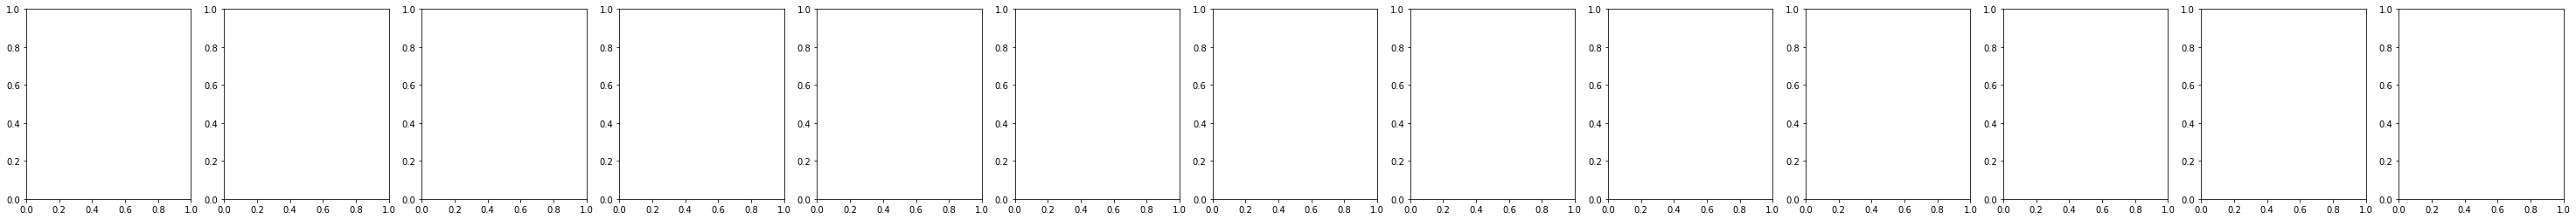

In [9]:
testNames = [
    "Mean Synchronization",
    "STD Synchronization",
    "Maximal Offdiag Value",
    "Mean weighted in-degree",
    "STD weighted in-degree",
    "Mean weighted out-degree",
    "STD weighted out-degree",
    "Average normalized total CC",
    "Average non-normalized total CC",
    "Average normalized in CC",
    "Average non-normalized in CC",
    "Average normalized out CC",
    "Average non-normalized out CC"]
nTest = len(testNames)

fig, ax = plt.subplots(ncols=nTest, figsize=(nTest*4, 4))

for mousename in mice:
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:    
        dataIdxs = list(mouseData["date"].index)
        
        testResults = np.zeros((len(dataIdxs), nTest))
        for i, dataIdx in enumerate(dataIdxs):
            # Compute cross-correlation absolute value
            dataThis = dataNeuronal[dataIdx].transpose(2,1,0) #channel x time x trial for cross-corr
            cAbs = np.abs(crossCorr(dataThis, 0, 0)[0])
            
            # Compute connectivity metrics
            testResults[i] = np.array([
                *graph_lib.diagonal_dominance(cAbs),
                np.max(graph_lib.offdiag(cAbs)),
                np.mean(graph_lib.degree_in(cAbs)),
                np.std(graph_lib.degree_in(cAbs)),
                np.mean(graph_lib.degree_out(cAbs)),
                np.std(graph_lib.degree_out(cAbs)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='tot', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='tot', normDegree=False)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='in', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='in', normDegree=False)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='out', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='out', normDegree=False))
            ])
            
        for iTest in range(nTest):
            ax[iTest].plot(deltaDaysCentered[dataIdxs], testResults[:,iTest], label=mousename)

for iTest in range(nTest):
    ax[iTest].set_title(testNames[iTest])
    ax[iTest].set_xlabel("Days from start")
    #ax[iTest].legend()
plt.show()

## 1.2 Clustering of data

1. For each mouse, for each time, compute corr
2. Compute CC vs time (mean/var)
3. Plot for all mice
4. Then split Go/NoGO

In [ ]:
trialKeys = ['iGO', 'iNOGO']
nTrialKeys = len(trialKeys)


for mousename in mice[:1]:
    print(mousename)
    
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:
        dataIdxs = list(mouseData["date"].index)
        
        fig, ax = plt.subplots(ncols=nTrialKeys, figsize=(5*nTrialKeys,5))
        fig.suptitle(mousename)
        
        for iKey, trialKey in enumerate(trialKeys):
            for i, dataIdx in enumerate(dataIdxs):
                
                
                dataLabel = pathDataSets['data_path']['mousekey'][dataIdx]
                trialIdx = dataTrials[dataIdx][trialKey]
                dataThis = dataNeuronal[dataIdx][trialIdx-1]

                print("--", dataLabel, trialKey, len(trialIdx))

                nTrial, nTime, nChannel = dataThis.shape

                ccNoNorm = np.zeros(nTime)
                for iTime in range(nTime):
                    corrAbs = np.abs(corr(dataThis[:, iTime, :].T))
                    ccNoNorm[iTime] = np.mean(graph_lib.cl_coeff(corrAbs, normDegree=False))

                ax[iKey].plot(ccNoNorm, label=dataLabel)

            ax[iKey].set_title(trialKey)
            ax[iKey].legend()
plt.show()